### Setup

In [1]:
import math
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
sys.path.insert(1, os.getcwd().replace('preprocessing','')) # allows config import from one level above
import config as cfg

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

pd.set_option('display.max_columns', 500,'display.max_rows', 100)

In [2]:
y_back = 20 # reverse time for average calculation of past fights history (only relevant for XGBoost Input)
next_date = 'Mar. 13, 2021' # next fight night date 

### Combine Matches, Fighters, Profiles and Planned Fights in 1  DF

In [3]:
m = pd.read_csv(f"{cfg.path_data_output}{cfg.scrape_date}_Matches_List.csv")
f = pd.read_csv(f"{cfg.path_data_output}{cfg.scrape_date}_Fighters_List.csv")
p = pd.read_csv(f"{cfg.path_data_output}{cfg.scrape_date}_Profiles_List.csv")
n = pd.read_csv(f"{cfg.path_data_output}{cfg.scrape_date}_Plan_List.csv")
try:
    f.drop('Unnamed: 0',axis=1,inplace=True)
    p.drop('Unnamed: 0',axis=1,inplace=True)
except: pass

In [4]:
m.MID.value_counts().value_counts()

2    7741
1      79
Name: MID, dtype: int64

In [5]:
# assert len(m.MID.value_counts().value_counts()) == 1 # every match has been scraped twice, error not crucial if something goes wrong just means some data is missing
# m.MID.value_counts().value_counts()

In [6]:
# # ATTENTION MANUAL CORRECTION OF NAMES REQUIRED DUE TO MISTAKES ON UFC STATS PAGE -> Has been corrected by UFC

# def fanual_correct(first_old,first_new, second):
#     f.loc[(f.First == first_old)&(f.Last == second),'First'] = first_new


# fanual_correct('Rogerio','Minotauro','Nogueira')

# def manual_correct(name_old,name_new):
#     m.loc[m.Fighter_1 == name_old,'Fighter_1'] = name_new
#     m.loc[m.Fighter_2 == name_old,'Fighter_2'] = name_new
#     n.loc[n.Fighter_1 == name_old,'Fighter_1'] = name_new
#     n.loc[n.Fighter_2 == name_old,'Fighter_2'] = name_new
    

# manual_correct('Ronaldo Souza','Jacare Souza')
# manual_correct('Rafael Cavalcante','Rafael Feijao')
# manual_correct('Michael Chandler','Mike Chandler')
# manual_correct('Mirko Filipovic','Mirko Cro Cop')
# manual_correct('Quinton Jackson','Rampage Jackson')
# manual_correct('Cristiane Justino','Cris Cyborg')
# manual_correct('Antonio Rodrigo Nogueira','Minotauro Nogueira')
# manual_correct('Rogerio Nogueira','Minotauro Nogueira')
# manual_correct('Antonio Rogerio Nogueira','Minotauro Nogueira')
# manual_correct('Antonio Rodrigo Nogueira','Minotauro Nogueira')

In [7]:
# only QS
# f[f.Last.str.startswith('T')].shape#.iloc[-15:]
# for le in list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
#     f[f.Last.str.startswith(le)].iloc[0:3]

In [8]:
n = n[n.duplicated(['Fighter_1'],keep=False)] # delete fights if only one fighter was scraped, e.g., new fighter
n = n.sort_values('Fighter_1') # TODO: check why not keep FID -> better keep

In [9]:
n = n[n.Fighter_1 != 'Error']
n = n.reset_index(drop = True)

In [10]:
n['MID'] = ['next_' + f'{i + (i+1)%2:03d}' for i in n.index]
n['Date'] = next_date

In [11]:
r = pd.merge(m,n, how = 'outer')

In [12]:
r = pd.merge(r, f, on = 'FID') 

In [13]:
r = pd.merge(r, p.loc[:,['DOB','FID']]) # only add DOB

In [14]:
assert m.MID.value_counts().sum() == m.shape[0] # QS

In [15]:
assert r.shape[0] == m.shape[0]+n.shape[0] # QS

In [16]:
assert r[r.MID.str.startswith('next')].shape[0] == n.shape[0] # QS

In [17]:
r.loc[(r.Fighter_1 == 'Robbie Lawler') |(r.Fighter_2 == 'Robbie Lawler')].drop_duplicates('MID').shape


(34, 69)

### Preprocess DF for  Duplicates, Dataformats etc.

In [18]:
r.insert(2, 'Result', r['Result_F1'].replace({'W': 1, 'L': 0, 'NC':0.5,'D':0.5}), allow_duplicates=True) 

In [19]:
liste = list(r.columns[-11:])+['FID']

In [20]:
for column in liste:
    r[column+'_F1'] = ''
for column in liste:
    r[column+'_F2'] = ''

In [21]:
for col in liste:
    r[col+'_F1'] = [r[col][i] if r.Fighter_1[i] == str(r.First[i]) + ' ' +str(r.Last[i]) else None for i in r.index]
    r[col+'_F2'] = [r[col][i] if r.Fighter_2[i] == str(r.First[i]) + ' ' +str(r.Last[i]) else None for i in r.index]

In [22]:
# CHECK FOR INVALID NAMES HERE
r.FID_F2.isna().sum()
assert r[(r.FID_F2.isna())&(r.FID_F1.isna())].loc[:,['Fighter_1','Fighter_2','First','Last','Nick']].shape[0] == 0
assert r[(r.FID_F2.isna())&(r.FID_F1.isna())].shape[0] == 0

7801

In [23]:
r.sort_values('MID',inplace = True)
r.set_index('MID',inplace=True)
r.drop_duplicates(inplace = True)
r.reset_index(inplace=True)

In [24]:
s1 = r.drop_duplicates('MID',keep='first').set_index('MID')
s2 = r.drop_duplicates('MID',keep='last').set_index('MID')

In [25]:
r.MID.value_counts().value_counts()

2    7770
1      79
Name: MID, dtype: int64

In [26]:
r = s1.combine_first(s2) # TODO: maybe throw away fighter were only one match side was available

In [27]:
r.sort_values('MID',inplace = True)

In [28]:
del s1
del s2

In [29]:
r.drop(['FID','First','Last','Nick','HT','WT','Reach','Stance','W','L','D','DOB'],axis = 1, inplace = True)

In [30]:
r.Date = pd.to_datetime(r.Date, infer_datetime_format=True)

In [31]:
r.loc[r.DOB_F1 == '--','DOB_F1'] = None
r.loc[r.DOB_F2 == '--','DOB_F2'] = None

In [32]:
r['DOB_F1'] = pd.to_datetime(r.DOB_F1, infer_datetime_format=True)
r['DOB_F2'] = pd.to_datetime(r.DOB_F2, infer_datetime_format=True)

In [33]:
r['HT_cm_F1'] = [(int(r.HT_F1.loc[i].split("'")[0])*12+int(r.HT_F1.loc[i].split("'")[1].replace('"','').replace(' ','')))*2.54 if r.HT_F1.loc[i] != '--' and r.HT_F1.loc[i] == r.HT_F1.loc[i] and r.HT_F1.loc[i] != None else '' for i in r.index]
r['HT_cm_F2'] = [(int(r.HT_F2.loc[i].split("'")[0])*12+int(r.HT_F2.loc[i].split("'")[1].replace('"','').replace(' ','')))*2.54 if r.HT_F2.loc[i] != '--' and r.HT_F2.loc[i] == r.HT_F2.loc[i] and r.HT_F2.loc[i] != None else '' for i in r.index]

In [34]:
r['Reach_cm_F1'] = [float(r.Reach_F1.loc[i].replace('"',''))*2.54 if r.Reach_F1.loc[i] != '--' and r.Reach_F1.loc[i] == r.Reach_F1.loc[i] and r.Reach_F1.loc[i] != None else '' for i in r.index]
r['Reach_cm_F2'] = [float(r.Reach_F2.loc[i].replace('"',''))*2.54 if r.Reach_F2.loc[i] != '--' and r.Reach_F2.loc[i] == r.Reach_F2.loc[i] and r.Reach_F2.loc[i] != None else '' for i in r.index]

In [35]:
# r['WT_lbs_F1'] = [int(i.split(' ')[0]) if type(i) == str and i != '--' else None for i in r.WT_F1] # not needed anymore as this is data leakage basically
# r['WT_lbs_F2'] = [int(i.split(' ')[0]) if type(i) == str and i != '--' else None for i in r.WT_F2]

In [36]:
r.to_csv(f"{cfg.path_data_output}{cfg.scrape_date}_Combined.csv")

### Balance Wins vs. Losses

In [37]:
r = pd.read_csv(f"{cfg.path_data_output}{cfg.scrape_date}_Combined.csv",index_col = 0)

In [38]:
r.Date = pd.to_datetime(r.Date, infer_datetime_format=True)
r['DOB_F1'] = pd.to_datetime(r.DOB_F1, infer_datetime_format=True)
r['DOB_F2'] = pd.to_datetime(r.DOB_F2, infer_datetime_format=True)

In [39]:
assert r.index.shape[0] == r.index.nunique()

In [40]:
r.Result_F1.value_counts(dropna=False)[np.ix_(r.Result_F1.value_counts(dropna=False).index.isna())[0][0]]

np.ix_(r.Result_F1.value_counts(dropna=False).index.isna())[0][0]
r.Result_F1.value_counts(dropna=False).index

29

4

Index(['W', 'L', 'NC', 'D', nan], dtype='object')

In [41]:
s = int(r.Result_F1.value_counts()['W']-round((r.shape[0]-r.Result_F1.value_counts()['NC']-r.Result_F1.value_counts()['D']\
                                              -r.Result_F1.value_counts(dropna=False)[np.ix_(r.Result_F1.value_counts(dropna=False).index.isna())[0][0]])/2))
sample = r[r.Result_F1 == 'W'].sample(s,random_state=42)
rest = r.drop(sample.index,axis=0)

In [42]:
s
r.Result_F1.value_counts(dropna = False)

1826

W      5668
L      2016
NC       75
D        61
NaN      29
Name: Result_F1, dtype: int64

In [43]:
a = list(sample.loc[:,'Fighter_1':].columns)
b = [i[:-1]+str(int(i[-1:])*-1+3) for i in a]

In [44]:
dictionary = dict(zip(a, b))

In [45]:
sample = sample.rename(columns=dictionary)

In [46]:
sample.Result_F1 = 'L'
sample.Result = 0

In [47]:
frames = [rest,sample]
r = pd.concat(frames,sort=False)

In [49]:
r.to_csv(f"{cfg.path_data_output}{cfg.scrape_date}_balanced.csv") 

In [50]:
r.shape
r.sample(3)
r.Method.value_counts()
r.index.nunique()
r.loc[(r.Fighter_1 == 'Israel Adesanya')|(r.Fighter_2 == 'Israel Adesanya')].sort_values('Date')

(7849, 85)

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0239f24134022656,1.0,W,UFC 147: Silva vs Franklin 2,2012-06-23,KO/TKO,1.0,2:28,HEAVYWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Punch to Head At Distance,Fabricio Werdum,Mike Russow,1.0,0.0,31.0,58.0,3.0,16.0,31.0,58.0,3.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,52.0,3.0,16.0,2.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,18.0,37.0,3.0,16.0,0.0,2.0,0.0,0.0,13.0,19.0,0.0,0.0,Fabricio,Werdum,Vai Cavalo,"6' 4""",231 lbs.,"77.0""",Orthodox,24.0,9.0,1.0,1977-07-30,3415.0,Mike,Russow,NaN,"6' 1""",255 lbs.,"73.0""",Orthodox,15.0,3.0,0.0,1976-09-11,2757.0,193.04,185.42,195.58,185.42
dc7ba55ca764cfbe,1.0,W,UFC Fight Night: Lewis vs. Hunt,2017-06-10,KO/TKO,2.0,3:02,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),Neil Swailes,Knee to Head In Clinch,Dan Hooker,Ross Pearson,1.0,0.0,69.0,141.0,38.0,88.0,74.0,146.0,38.0,88.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,108.0,15.0,59.0,6.0,8.0,13.0,18.0,23.0,25.0,10.0,11.0,68.0,140.0,36.0,86.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,Dan,Hooker,The Hangman,"6' 0""",155 lbs.,"75.0""",Switch,20.0,9.0,0.0,1990-02-13,1376.0,Ross,Pearson,The Real Deal,"5' 8""",155 lbs.,"69.0""",Orthodox,20.0,16.0,0.0,1984-09-26,2445.0,182.88,172.72,190.50,175.26
26024189488b22a5,1.0,W,Strikeforce - Miami,2010-01-30,SUB,1.0,1:47,FEATHERWEIGHT BOUT,3 Rnd (5-5-5),Frank Gentile,Armbar,Pablo Alfonso,Marcos da Matta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pablo,Alfonso,The Hurricane,"5' 8""",145 lbs.,--,NaN,9.0,7.0,0.0,1983-05-09,56.0,Marcos,da Matta,Parrumpinha,"5' 4""",145 lbs.,--,NaN,11.0,3.0,0.0,1973-03-18,672.0,172.72,162.56,NaN,NaN


KO/TKO        2657
U-DEC         2501
SUB           1777
S-DEC          691
M-DEC           74
Overturned      47
CNC             29
DQ              27
Other           14
Decision         3
Name: Method, dtype: int64

7849

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1cd5d5e271b646a3,0.0,L,UFC 221: Romero vs. Rockhold,2018-02-10,KO/TKO,2.0,3:37,MIDDLEWEIGHT BOUT,3 Rnd (5-5-5),Steve Perceval,Punches to Head At Distance,Rob Wilkinson,Israel Adesanya,0.0,1.0,22.0,46.0,52.0,75.0,33.0,59.0,70.0,94.0,3.0,15.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,22.0,35.0,56.0,5.0,10.0,13.0,13.0,11.0,14.0,4.0,6.0,7.0,26.0,28.0,45.0,15.0,20.0,24.0,30.0,0.0,0.0,0.0,0.0,Rob,Wilkinson,Razor,"6' 3""",185 lbs.,"80.0""",Orthodox,11.0,2.0,0.0,1992-02-22,3438.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,190.50,193.04,203.20,203.20
b8b9a8e504d51ba5,1.0,W,UFC Fight Night: Poirier vs. Gaethje,2018-04-14,S-DEC,3.0,5:00,MIDDLEWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Derek Cleary 29 - 28. Chris Lee 28 - 29. Chris...,Israel Adesanya,Marvin Vettori,0.0,0.0,57.0,123.0,46.0,154.0,67.0,134.0,60.0,169.0,0.0,1.0,2.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,31.0,92.0,20.0,122.0,11.0,12.0,7.0,8.0,15.0,19.0,19.0,24.0,57.0,123.0,44.0,152.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,Marvin,Vettori,The Italian Dream,"6' 0""",185 lbs.,"74.0""",Southpaw,15.0,4.0,1.0,1993-09-20,3329.0,193.04,182.88,203.20,187.96
247f9e56965a1c07,0.0,L,The Ultimate Fighter: Undefeated Finale,2018-07-06,U-DEC,5.0,5:00,MIDDLEWEIGHT BOUT,5 Rnd (5-5-5-5-5),Herb Dean,Sal D'amato 45 - 50. Derek Cleary 45 - 50. Chr...,Brad Tavares,Israel Adesanya,0.0,0.0,40.0,174.0,119.0,215.0,46.0,181.0,127.0,223.0,1.0,12.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,34.0,163.0,61.0,144.0,3.0,8.0,21.0,29.0,3.0,3.0,37.0,42.0,37.0,164.0,99.0,192.0,1.0,8.0,12.0,14.0,2.0,2.0,8.0,9.0,Brad,Tavares,NaN,"6' 1""",185 lbs.,"74.0""",Orthodox,17.0,7.0,0.0,1987-12-21,3171.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,185.42,193.04,187.96,203.20
e4e1d12441b90866,0.0,L,UFC 230: Cormier vs. Lewis,2018-11-03,KO/TKO,1.0,4:51,MIDDLEWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Punches to Head At Distance,Derek Brunson,Israel Adesanya,0.0,3.0,3.0,14.0,13.0,23.0,9.0,23.0,15.0,25.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,9.0,16.0,0.0,2.0,3.0,4.0,1.0,1.0,1.0,3.0,2.0,13.0,11.0,19.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,Derek,Brunson,NaN,"6' 1""",185 lbs.,"77.0""",Southpaw,21.0,7.0,0.0,1984-01-04,383.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,185.42,193.04,195.58,203.20
4eb91cfc892a108e,1.0,W,UFC 234: Adesanya vs. Silva,2019-02-09,U-DEC,3.0,5:00,MIDDLEWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Charlie Keech 30 - 27. Albert Shen 30 - 27. Ga...,Israel Adesanya,Anderson Silva,0.0,0.0,65.0,132.0,31.0,72.0,65.0,132.0,34.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,79.0,16.0,49.0,9.0,22.0,8.0,12.0,29.0,31.0,7.0,11.0,63.0,129.0,26.0,67.0,2.0,3.0,5.0,5.0,0.0,0.0,0.0,0.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,Anderson,Silva,The Spider,"6' 2""",185 lbs.,"77.0""",Southpaw,34.0,10.0,0.0,1975-04-14,2941.0,193.04,187.96,203.20,195.58
9bfda7c26578aaac,0.0,L,UFC 236: Holloway vs. Poirier 2,2019-04-13,U-DEC,5.0,5:00,UFC INTERIM MIDDLEWEIGHT TITLE BOUT,5 Rnd (

###  Start from Balanced - Feature Engineering:
- ~~Average Fight Time (Event Level)~~
- ~~Age (Event Level)~~
- ~~Win / Losses at Event Date ~~
- ~~Strikes Landed per Min. (SLpM)~~
- ~~Striking Accuracy~~
- ~~Strikes Absorbed per Min. (SApM)~~
- ~~Defense~~
- ~~Takedowns Average/15 min.~~
- ~~Takedown Accuracy~~
- ~~Takedown Defense~~
- ~~Submission Average/15 min.~~
- ~~Time since last match~~
- ~~ELO rate~~
- ~~PCA / tSNE on Targeting etc.~~
- Avg Ground etc. per Win seperate per Loss
- Multiple encounters between same fighters
- Kellys Criterium for Betting Amount Optimization


In [51]:
r = pd.read_csv(f"{cfg.path_data_output}{cfg.scrape_date}_balanced.csv",index_col = 0) # TODO: Pathes in confix auslagern
r.loc[:,['Date','DOB_F1','DOB_F2']] = r.loc[:, ['Date','DOB_F1','DOB_F2']].apply(pd.to_datetime)

In [52]:
r.shape
r.index.nunique()
r.Result_F1.value_counts(dropna=False)

(7849, 85)

7849

L      3842
W      3842
NC       75
D        61
NaN      29
Name: Result_F1, dtype: int64

##### ELO Ranking

In [53]:
r = r.sort_values('Date')
# r.isna().sum()

In [54]:
# get Tracker for ELO values
fids = list(pd.Series(pd.Series(list(r.FID_F1.unique())+list(r.FID_F2.unique())).unique()))
tracker = pd.DataFrame([fids,[0]*len(fids)]).T
tracker.columns = ['FID','elo']
tracker.set_index('FID',inplace = True)
tracker.sort_index(inplace = True)

In [55]:
r['elo_F1'] = 0
r['elo_F2'] = 0
r['eloprob_F1'] = 0.5
r['eloprob_F2'] = 0.5

In [56]:
# get ELO
for i in r.index:
    fid1 = r.loc[i,'FID_F1']
    fid2 = r.loc[i,'FID_F2']
    
    if fid1 == fid1: r.loc[i,'elo_F1'] = tracker.loc[fid1,'elo']
    if fid2 == fid2: r.loc[i,'elo_F2'] = tracker.loc[fid2,'elo']
    
    r.loc[i,'eloprob_F1'] = 1/(1+10**((tracker.loc[fid2,'elo']-tracker.loc[fid1,'elo'])/400))
    r.loc[i,'eloprob_F2'] = 1/(1+10**((tracker.loc[fid1,'elo']-tracker.loc[fid2,'elo'])/400))
    
    
    if fid1 == fid1: tracker.loc[fid1,'elo'] = tracker.loc[fid1,'elo']+20*(r.loc[i,'Result']-r.loc[i,'eloprob_F1'])
    if fid2 == fid2: tracker.loc[fid2,'elo'] = tracker.loc[fid2,'elo']+20*((r.loc[i,'Result']*-1+1)-r.loc[i,'eloprob_F2']) #here was a mistake

In [57]:
tracker = pd.merge(tracker,f.loc[:,'First':'Nick'],left_index=True,right_index=True) # Shape not identical, bc not all fighters have eventsb
# tracker.to_csv(f'{date}_elo_rankings.csv')

In [58]:
r.head(1)

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
46acd54cc0c905fb,0.0,L,UFC 1: The Beginning,1993-11-12,SUB,1.0,1:49,OPEN WEIGHT BOUT,No Time Limit,Joao Alberto Barreto,Heel Hook From Guard,Patrick Smith,Ken Shamrock,0.0,0.0,4.0,8.0,1.0,1.0,16.0,20.0,4.0,4.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,6.0,1.0,1.0,Patrick,Smith,NaN,"6' 2""",225 lbs.,--,Orthodox,20.0,17.0,0.0,1963-08-28,2990.0,Ken,Shamrock,The World's Most Dangerous Man,"6' 1""",205 lbs.,"72.0""",Orthodox,28.0,17.0,2.0,1964-02-11,2911.0,187.96,185.42,NaN,182.88,0.0,0.0,0.5,0.5


In [59]:
r['elo_prediction'] = r.eloprob_F1 > r.eloprob_F2

In [60]:
table = r.loc[(r.eloprob_F1 != r.eloprob_F2)&(r.Result != 0.5)].groupby(['elo_prediction','Result']).size()
r.loc[(r.eloprob_F1 != r.eloprob_F2)&(r.Result != 0.5)].groupby(['elo_prediction','Result']).size()

elo_prediction  Result
False           0.0       1851
                1.0       1149
True            0.0       1701
                1.0       2325
dtype: int64

In [61]:
table = pd.DataFrame(table)
table = table.reset_index()

In [62]:
table
(table.loc[(table.elo_prediction == True)&(table.Result == 1),0].item() + table.loc[(table.elo_prediction == False)&(table.Result == 0),0].item()) / table.loc[:,0].sum()

,elo_prediction,Result,0
0,False,0.0,1851
1,False,1.0,1149
2,True,0.0,1701
3,True,1.0,2325


0.5943637916310845

In [3]:
# r[r.Fighter_2 == 'Khabib Nurmagomedov'].sort_values('Date')
# r.sort_values('elo_F1',ascending = False).head(30)[['Fighter_1','elo_F1']]
# r.sort_values('elo_F2',ascending = False).head(30)[['Fighter_2','elo_F2']]

##### Age, Length, W-H-R Deltas

In [64]:
# Age at Fight
r['age_F1'] = round((r.loc[:,'Date']-r.loc[:,'DOB_F1']).dt.days/365,1)
r['age_F2'] = round((r.loc[:,'Date']-r.loc[:,'DOB_F2']).dt.days/365,1)

In [65]:
# Length of Fight
r['fight_time'] = None
for i in r.index:
    try:
        if (r.loc[i,'T_Format'] == '3 Rnd (5-5-5)') or (r.loc[i,'T_Format'] == '5 Rnd (5-5-5-5-5)') or (r.loc[i,'T_Format'] == '2 Rnd (5-5)') or (r.loc[i,'T_Format'] == '3 Rnd + OT (5-5-5-5)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*5+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '2 Rnd (10-5)') or (r.loc[i,'T_Format'] == '3 Rnd (10-5-5)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*10-max((r.loc[i,'Round']-2)*5,0)+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '3 Rnd (3-3-3)') or (r.loc[i,'T_Format'] == '2 Rnd (3-3)') or (r.loc[i,'T_Format'] == '5 Rnd (3-3-3-3-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*3+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60 
        elif (r.loc[i,'T_Format'] == '3 Rnd (3-3-3)') or (r.loc[i,'T_Format'] == '2 Rnd (3-3)') or (r.loc[i,'T_Format'] == '5 Rnd (3-3-3-3-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*3+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60 
        elif (r.loc[i,'T_Format'] == '3 Rnd (4-4-4)') or (r.loc[i,'T_Format'] == '2 Rnd (4-4)') or (r.loc[i,'T_Format'] == '5 Rnd (4-4-4-4-4)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*4+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60 
        elif (r.loc[i,'T_Format'] == '2 Rnd (10-10)') or (r.loc[i,'T_Format'] == '3 Rnd (8-8-8) '):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*10+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60 
        elif (r.loc[i,'T_Format'] == '3 Rnd (2-2-2)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*2+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '1 Rnd + OT (12-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*12+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '3 Rnd (10-10-10)') or (r.loc[i,'T_Format'] == '3 Rnd (10-10-5)') or (r.loc[i,'T_Format'] == '4 Rnd (10-10-10-10)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*10+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '1 Rnd + 2OT (15-3-3)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (15-10)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (15-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*15-max((r.loc[i,'Round']-2)*12,0)+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '1 Rnd + OT (30-5)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (31-5)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (30-3)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (27-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*30+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60 # not 100% precise
        else:
            r.loc[i,'fight_time'] = int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
    except: print(i)

r['fight_time'] = r.fight_time.astype('float64')
r['fight_time'] = r.fight_time.round(decimals = 1)

next_015
next_047
next_017
next_051
next_001
next_045
next_019
next_043
next_041
next_053
next_055
next_039
next_021
next_037
next_013
next_003
next_035
next_011
next_023
next_033
next_057
next_005
next_025
next_007
next_009
next_027
next_029
next_031
next_049


In [4]:
# r.loc[r.Fighter_2 == 'Conor McGregor']

In [67]:
#fight_time_share: divides fight_time by potential full round time
def get_pot_fight_time(i):
    try:
        return sum([int(n) for n in i.split('(')[1].replace(')','').split('-')])
    except:
        pass
#         print('NOT WORKING:',i)

r['fight_time_share'] = r.fight_time/r.T_Format.apply(lambda i: get_pot_fight_time(i))

In [68]:
r.loc[r.fight_time_share > 1,'fight_time_share'] = 1 # manual correction for minor inprecision, only relevant in 1 single case

In [70]:
# weight at event
weight_dict = {'strawweight':115,
              'flyweight':125,
              'bantamweight':135,
              'featherweight':145,
              'lightweight':155,
              'welterweight':170,
              'middleweight':185,
              'light heavyweight':205,
              'heavyweight':265,
              '135 lbs':135,
              '145 lbs':145}

def infer_weight(x):
    try:
        return [weight_dict[i] for i in weight_dict.keys() if i in x.lower()][0]
    except:
        pass
    
r.loc[:,'weight_class'] = r.Type.apply(lambda x: infer_weight(x))
r = r.drop(['WT_F1','WT_F2'],axis=1)

In [71]:
# TODO : Weigth raus, replace by infer weigth from Type

In [72]:
# get deltas
r['delta_h'] = r.HT_cm_F1-r.HT_cm_F2
r['delta_r'] = r.Reach_cm_F1 - r.Reach_cm_F2

##### Basic Fight History for Strikes, Grappling, Submissions

In [74]:
# cols for history fight stats
cols = ['w2d','l2d','time_avg','slpm_avg','stracc_avg','sapm_avg','def_avg','td_avg','tdacc_avg','tddef_avg','sub_avg','lastfight','fight_count']
cols = [i+'_F1' for i in cols] + [i+'_F2' for i in cols]
for c in cols:
    r[c] = None

In [75]:
# function for retrieving weighted history fight stats
def past_fight_stats(fid, mdate, years_back):
    sub = r[((r.FID_F1 == fid)|(r.FID_F2 == fid))&(r.Date < mdate)&(r.Date > mdate-pd.DateOffset(years=years_back))].sort_values('Date')

    # get avg fight time
    time_avg = sub.fight_time.mean()

    try:
        # get outside UFC results to add later on
        if r[(r.FID_F1 == fid)].shape[0] != 0:    
            non_ufc_w = r.loc[r.FID_F1 == fid,'W_F1'].iloc[0]-r.loc[r.FID_F1 == fid,'Result'].sum()-(r.loc[r.FID_F2 == fid,'Result']*-1+1).sum()
            non_ufc_l = r.loc[r.FID_F1 == fid,'L_F1'].iloc[0]-r.loc[r.FID_F2 == fid,'Result'].sum()-(r.loc[r.FID_F1 == fid,'Result']*-1+1).sum()
        else:  
            non_ufc_w = r.loc[r.FID_F2 == fid,'W_F2'].iloc[0]-(r.loc[r.FID_F2 == fid,'Result']*-1+1).sum()
            non_ufc_l = r.loc[r.FID_F2 == fid,'L_F2'].iloc[0]-r.loc[r.FID_F2 == fid,'Result'].sum()
    except:
        non_ufc_w, non_ufc_l = 0, 0


    # get win and losses inside ufc plus outside
    w2d = sub.loc[sub.FID_F1 == fid,'Result'].sum()+(sub.loc[sub.FID_F2 == fid,'Result']*-1+1).sum() + non_ufc_w
    l2d = sub.loc[sub.FID_F2 == fid,'Result'].sum()+(sub.loc[sub.FID_F1 == fid,'Result']*-1+1).sum() + non_ufc_l

    if time_avg == time_avg:
        
        # strike measures POTENTIAL WEIGHING BY OPPONENT OR TIME
        # Active Strike Measures
        try:
            sigstr_t = sub.loc[sub.FID_F1 == fid,'SigStr_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'SigStr_t_2'].sum()
            sigstr_e = sub.loc[sub.FID_F1 == fid,'SigStr_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'SigStr_e_2'].sum()
            stracc_avg = sigstr_e/sigstr_t
            slpm_avg = sigstr_e/math.ceil(sub.fight_time.sum())
        except:
            stracc_avg, slpm_avg = 0, 0

        # Passive Strike Measures
        try:
            oppss_t = sub.loc[sub.FID_F1 == fid,'SigStr_t_2'].sum() + sub.loc[sub.FID_F2 == fid,'SigStr_t_1'].sum()
            oppss_e = sub.loc[sub.FID_F1 == fid,'SigStr_e_2'].sum() + sub.loc[sub.FID_F2 == fid,'SigStr_e_1'].sum()
            def_avg = (oppss_t-oppss_e)/oppss_t
            sapm_avg = oppss_e/math.ceil(sub.fight_time.sum())
        except:
            def_avg, sapm_avg = None, 0

        # Grappling Measures
        # Active Takedown
        try:
            td_e = sub.loc[sub.FID_F1 == fid,'TD_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'TD_e_2'].sum()
            td_t = sub.loc[sub.FID_F1 == fid,'TD_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'TD_t_2'].sum()
            td_avg = td_e*15/math.ceil(sub.fight_time.sum())
            tdacc_avg = td_e/td_t
        except:
            tdacc_avg, td_avg = None, 0

        # Defense Takedown
        try:
            optd_e = sub.loc[sub.FID_F1 == fid,'TD_e_2'].sum() + sub.loc[sub.FID_F2 == fid,'TD_e_1'].sum()
            optd_t = sub.loc[sub.FID_F1 == fid,'TD_t_2'].sum() + sub.loc[sub.FID_F2 == fid,'TD_t_1'].sum()
            tddef_avg = (optd_t-optd_e)/optd_t
        except:
            tddef_avg = None

        # Submissions
        try:
            sub_avg = (sub.loc[sub.FID_F1 == fid,'SUB_1'].sum() + sub.loc[sub.FID_F2 == fid,'SUB_2'].sum())*15/math.ceil(sub.fight_time.sum())
        except:
            sub_avg = 0
            
        try:
            lastfight = round((mdate-sub.Date.max()).days*12/365,1)
        except:
            lastfight = None
    
    else:
        time_avg,slpm_avg,stracc_avg,sapm_avg,def_avg,td_avg,tdacc_avg,tddef_avg,sub_avg,lastfight = [None]*10
        
    return  [w2d,l2d,time_avg,slpm_avg,stracc_avg,sapm_avg,def_avg,td_avg,tdacc_avg,tddef_avg,sub_avg,lastfight,sub.shape[0]]

In [76]:
# loop through df to get history fight stats
for i in r.index:
    r.loc[i,'w2d_F1':'fight_count_F1'] = past_fight_stats(r.loc[i,'FID_F1'],r.loc[i,'Date'],y_back)
    r.loc[i,'w2d_F2':'fight_count_F2'] = past_fight_stats(r.loc[i,'FID_F2'],r.loc[i,'Date'],y_back)
    

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

In [77]:
# fid = r.loc['5655639baecd8f6a','FID_F1']
# years_back = 20
# mdate =r.loc['5655639baecd8f6a','Date']
# sub = r[((r.FID_F1 == fid)|(r.FID_F2 == fid))&(r.Date < mdate)&(r.Date > mdate-pd.DateOffset(years=years_back))].sort_values('Date')

##### Detail Fight History (Target, Position, Round)

In [79]:
# cols for detail fight stats
cols = [i.replace('_e_','_perT_') if '_e_' in i else i.replace('_t_','_acc_') for i in r.loc[:,'Head_e_1':'Ground_t_2'].columns] + [i.replace('_','_perT_') for i in r.loc[:,'PASS_1':'REV_2'].columns]
cols.append('KD_perT_1'); cols.append('KD_perT_2'); 
for c in cols:
    r[c] = None

In [80]:
# function for retrieving history fight stats
def past_fight_dets(fid, mdate, years_back):

    sub = r[((r.FID_F1 == fid)|(r.FID_F2 == fid))&(r.Date < mdate)&(r.Date > mdate-pd.DateOffset(years=years_back))].sort_values('Date')
    
    if sub.shape[0] != 0:

        try:
            ht = sub.loc[sub.FID_F1 == fid,'Head_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Head_t_2'].sum()
            he = sub.loc[sub.FID_F1 == fid,'Head_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Head_e_2'].sum()
            Head_acc = he/ht
            Head_perT = he*5/math.ceil(sub.fight_time.sum())
        except:
            Head_acc, Head_perT = None, 0

        try:
            bt = sub.loc[sub.FID_F1 == fid,'Body_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Body_t_2'].sum()
            be = sub.loc[sub.FID_F1 == fid,'Body_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Body_e_2'].sum()
            Body_acc = be/bt
            Body_perT = be*5/math.ceil(sub.fight_time.sum())
        except:
            Body_acc, Body_perT = None, 0

        try:
            lt = sub.loc[sub.FID_F1 == fid,'Leg_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Leg_t_2'].sum()
            le = sub.loc[sub.FID_F1 == fid,'Leg_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Leg_e_2'].sum()
            Leg_acc = le/lt
            Leg_perT = le*5/math.ceil(sub.fight_time.sum())
        except:
            Leg_acc, Leg_perT = None, 0

        try:
            dt = sub.loc[sub.FID_F1 == fid,'Distance_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Distance_t_2'].sum()
            de = sub.loc[sub.FID_F1 == fid,'Distance_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Distance_e_2'].sum()
            Distance_acc = de/dt
            Distance_perT = de*5/math.ceil(sub.fight_time.sum())
        except:
            Distance_acc, Distance_perT = None, 0

        try:
            ct = sub.loc[sub.FID_F1 == fid,'Clinch_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Clinch_t_2'].sum()
            ce = sub.loc[sub.FID_F1 == fid,'Clinch_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Clinch_e_2'].sum()
            Clinch_acc = ce/ct
            Clinch_perT = ce*5/math.ceil(sub.fight_time.sum())
        except:
            Clinch_acc, Clinch_perT = None, 0

        try:
            gt = sub.loc[sub.FID_F1 == fid,'Ground_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Ground_t_2'].sum()
            ge = sub.loc[sub.FID_F1 == fid,'Ground_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Ground_e_2'].sum()
            Ground_acc = ge/gt
            Ground_perT = ge*5/math.ceil(sub.fight_time.sum())
        except:
            Ground_acc, Ground_perT = None, 0

        try:
            k = sub.loc[sub.FID_F1 == fid,'KD_1'].sum() + sub.loc[sub.FID_F2 == fid,'KD_2'].sum()
            KD_perT = k*15/math.ceil(sub.fight_time.sum())
        except:
            KD_perT = 0

        try:
            p = sub.loc[sub.FID_F1 == fid,'PASS_1'].sum() + sub.loc[sub.FID_F2 == fid,'PASS_2'].sum()
            PASS_perT = p*15/math.ceil(sub.fight_time.sum())
        except:
            PASS_perT = 0

        try:
            rv = sub.loc[sub.FID_F1 == fid,'REV_1'].sum() + sub.loc[sub.FID_F2 == fid,'REV_2'].sum()
            REV_perT = rv*15/math.ceil(sub.fight_time.sum())
        except:
            REV_perT = 0
    
    else:
        Head_perT,Head_acc,Body_perT,Body_acc,Leg_perT,Leg_acc,Distance_perT,Distance_acc,Clinch_perT,Clinch_acc,Ground_perT,Ground_acc,PASS_perT,REV_perT,KD_perT = [None]*15

    return  [Head_perT,Head_acc,Body_perT,Body_acc,Leg_perT,Leg_acc,Distance_perT,Distance_acc,Clinch_perT,Clinch_acc,Ground_perT,Ground_acc,PASS_perT,REV_perT,KD_perT]

In [81]:
# loop through df to get details fight stats
for i in r.index:
    res1 = past_fight_dets(r.loc[i,'FID_F1'],r.loc[i,'Date'],y_back)
    res2 = past_fight_dets(r.loc[i,'FID_F2'],r.loc[i,'Date'],y_back)
    c1, c2 = 0,0

    for c in r.loc[:,'Head_perT_1':'KD_perT_2'].columns:
        if c[-1] == '1':
            r.loc[i,c] = res1[c1]
            c1+=1
        else:
            r.loc[i,c] = res2[c2]
            c2+=1

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by Intera

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by Intera

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\si

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Mattis\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: inva

##### stance adaptation

In [82]:
r.loc[:,'Stance_F1'] = r.Stance_F1.str.replace('Orthodox','1').str.replace('Southpaw','0').str.replace('Switch','0.5').str.replace('Open Stance','1').str.replace('Sideways','1').astype(float)
r.loc[:,'Stance_F2'] = r.Stance_F2.str.replace('Orthodox','1').str.replace('Southpaw','0').str.replace('Switch','0.5').str.replace('Open Stance','1').str.replace('Sideways','1').astype(float)

In [83]:
r.to_csv(f'{cfg.path_data_output}{cfg.scrape_date}_features_{y_back}_y_back.csv')

In [84]:
# old weight class calculation
# r['weight_class'] = ''
# for i in r.index:
#     if (r.loc[i,'Type'] != r.loc[i,'Type']):
#         r.loc[i,'weight_class'] =  np.nansum([r.loc[i,'WT_lbs_F1'],r.loc[i,'WT_lbs_F2']])/\
#         (2-np.isnan(np.array([r.loc[i,'WT_lbs_F1'],r.loc[i,'WT_lbs_F2']])).sum())
        
#     elif 'STRAWWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 115.0
#     elif 'FLYWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 125.0        
#     elif 'BANTAMWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 135.0        
#     elif 'FEATHERWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 145.0 
#     elif 'LIGHTWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 155.0 
#     elif 'WELTERWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 170.0        
#     elif 'MIDDLEWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 185.0  
#     elif 'LIGHT HEAVYWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 205.0
#     elif 'HEAVYWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 265.0        
#     else: r.loc[i,'weight_class'] = np.nansum([r.loc[i,'WT_lbs_F1'],r.loc[i,'WT_lbs_F2']])/\
#         (2-np.isnan(np.array([r.loc[i,'WT_lbs_F1'],r.loc[i,'WT_lbs_F2']])).sum())

# r.weight_class.fillna(r.weight_class.median(),inplace=True)

### Split into pre fight and post fight information

In [85]:
# general_cols :    relevant for both sequential and pooled models (XGBoost, LSTM)
# pre_fight_cols :  relevant for pooled models (XGBoost)
# post_figth_cols : relevant for sequential models (LSTM)

In [86]:
general_cols = ['Result', 'Result_F1','Date','weight_class','FID_F1','FID_F2','Fighter_1','Fighter_2','Stance_F1','Stance_F2','HT_cm_F1', 
                'HT_cm_F2', 'Reach_cm_F1', 'Reach_cm_F2','elo_F1', 'elo_F2', 'eloprob_F1', 'eloprob_F2', 'elo_prediction',
       'age_F1', 'age_F2','delta_h','delta_r']

pre_fight_cols = ['w2d_F1', 'l2d_F1', 'time_avg_F1', 'slpm_avg_F1', 'stracc_avg_F1',
       'sapm_avg_F1', 'def_avg_F1', 'td_avg_F1', 'tdacc_avg_F1',
       'tddef_avg_F1', 'sub_avg_F1', 'lastfight_F1', 'fight_count_F1',
       'w2d_F2', 'l2d_F2', 'time_avg_F2', 'slpm_avg_F2', 'stracc_avg_F2',
       'sapm_avg_F2', 'def_avg_F2', 'td_avg_F2', 'tdacc_avg_F2',
       'tddef_avg_F2', 'sub_avg_F2', 'lastfight_F2', 'fight_count_F2',
       'Head_perT_1', 'Head_acc_1', 'Head_perT_2', 'Head_acc_2', 'Body_perT_1',
       'Body_acc_1', 'Body_perT_2', 'Body_acc_2', 'Leg_perT_1', 'Leg_acc_1',
       'Leg_perT_2', 'Leg_acc_2', 'Distance_perT_1', 'Distance_acc_1',
       'Distance_perT_2', 'Distance_acc_2', 'Clinch_perT_1', 'Clinch_acc_1',
       'Clinch_perT_2', 'Clinch_acc_2', 'Ground_perT_1', 'Ground_acc_1',
       'Ground_perT_2', 'Ground_acc_2', 'PASS_perT_1', 'PASS_perT_2',
       'REV_perT_1', 'REV_perT_2', 'KD_perT_1', 'KD_perT_2']

post_fight_cols = ['Method', 'Round', 'Time','fight_time','KD_1', 'KD_2', 'SigStr_e_1', 'SigStr_t_1', 'SigStr_e_2', 'SigStr_t_2',
       'TotStr_e_1', 'TotStr_t_1', 'TotStr_e_2', 'TotStr_t_2', 'TD_e_1',
       'TD_t_1', 'TD_e_2', 'TD_t_2', 'SUB_1', 'SUB_2', 'PASS_1', 'PASS_2',
       'REV_1', 'REV_2', 'Head_e_1', 'Head_t_1', 'Head_e_2', 'Head_t_2',
       'Body_e_1', 'Body_t_1', 'Body_e_2', 'Body_t_2', 'Leg_e_1', 'Leg_t_1',
       'Leg_e_2', 'Leg_t_2', 'Distance_e_1', 'Distance_t_1', 'Distance_e_2',
       'Distance_t_2', 'Clinch_e_1', 'Clinch_t_1', 'Clinch_e_2', 'Clinch_t_2',
       'Ground_e_1', 'Ground_t_1', 'Ground_e_2', 'Ground_t_2']

In [87]:
r.loc[r.Fighter_1 == 'Khabib Nurmagomedov',pre_fight_cols].iloc[-2,:].to_clipboard()

In [88]:
pre_fight = r.loc[:,general_cols+pre_fight_cols]
post_fight = r.loc[:,general_cols+post_fight_cols]

In [89]:
pre_fight.sample()
post_fight.sample()

,Result,Result_F1,Date,weight_class,FID_F1,FID_F2,Fighter_1,Fighter_2,Stance_F1,Stance_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,delta_h,delta_r,w2d_F1,l2d_F1,time_avg_F1,slpm_avg_F1,stracc_avg_F1,sapm_avg_F1,def_avg_F1,td_avg_F1,tdacc_avg_F1,tddef_avg_F1,sub_avg_F1,lastfight_F1,fight_count_F1,w2d_F2,l2d_F2,time_avg_F2,slpm_avg_F2,stracc_avg_F2,sapm_avg_F2,def_avg_F2,td_avg_F2,tdacc_avg_F2,tddef_avg_F2,sub_avg_F2,lastfight_F2,fight_count_F2,Head_perT_1,Head_acc_1,Head_perT_2,Head_acc_2,Body_perT_1,Body_acc_1,Body_perT_2,Body_acc_2,Leg_perT_1,Leg_acc_1,Leg_perT_2,Leg_acc_2,Distance_perT_1,Distance_acc_1,Distance_perT_2,Distance_acc_2,Clinch_perT_1,Clinch_acc_1,Clinch_perT_2,Clinch_acc_2,Ground_perT_1,Ground_acc_1,Ground_perT_2,Ground_acc_2,PASS_perT_1,PASS_perT_2,REV_perT_1,REV_perT_2,KD_perT_1,KD_perT_2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f208b79b0d78045b,0.0,L,2015-05-09,185.0,1605.0,86.0,Daniel Kelly,Sam Alvey,0.0,0.0,182.88,187.96,177.8,190.5,20.016101,10.862805,0.51317,0.48683,True,37.5,29.0,-5.08,-12.7,9.0,0.0,9.7,4.3,0.361345,3.65,0.78655,0.75,0.5,0.833333,0.75,2.8,2,25.0,6.0,6.966667,4.380952,0.502732,4.857143,0.514286,0.0,NaN,0.714286,0.0,2.5,3,19.5,0.340611,19.285714,0.490909,0.5,0.666667,2.380952,0.588235,1.5,1.0,0.238095,1.0,20.0,0.347826,10.238095,0.390909,1.25,0.714286,9.52381,0.634921,0.25,1.0,2.142857,0.9,1.5,0.714286,0.0,0.0,0.0,0.714286


,Result,Result_F1,Date,weight_class,FID_F1,FID_F2,Fighter_1,Fighter_2,Stance_F1,Stance_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,delta_h,delta_r,Method,Round,Time,fight_time,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54afe8c42e2062d6,0.0,L,2014-12-12,115.0,2601.0,561.0,Bec Rawlings,Heather Clark,1.0,1.0,167.64,167.64,162.56,162.56,0.0,0.0,0.5,0.5,False,25.8,34.3,0.0,0.0,U-DEC,3.0,5:00,15.0,0.0,0.0,69.0,118.0,56.0,99.0,90.0,147.0,85.0,136.0,0.0,2.0,1.0,5.0,0.0,1.0,0.0,4.0,0.0,0.0,45.0,89.0,33.0,66.0,6.0,10.0,15.0,23.0,18.0,19.0,8.0,10.0,43.0,82.0,29.0,64.0,25.0,35.0,21.0,27.0,1.0,1.0,6.0,8.0


In [91]:
pre_fight.loc[pre_fight.Fighter_1 == 'Conor McGregor']
post_fight.loc[post_fight.Fighter_1 == 'Khabib Nurmagomedov']

,Result,Result_F1,Date,weight_class,FID_F1,FID_F2,Fighter_1,Fighter_2,Stance_F1,Stance_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,delta_h,delta_r,w2d_F1,l2d_F1,time_avg_F1,slpm_avg_F1,stracc_avg_F1,sapm_avg_F1,def_avg_F1,td_avg_F1,tdacc_avg_F1,tddef_avg_F1,sub_avg_F1,lastfight_F1,fight_count_F1,w2d_F2,l2d_F2,time_avg_F2,slpm_avg_F2,stracc_avg_F2,sapm_avg_F2,def_avg_F2,td_avg_F2,tdacc_avg_F2,tddef_avg_F2,sub_avg_F2,lastfight_F2,fight_count_F2,Head_perT_1,Head_acc_1,Head_perT_2,Head_acc_2,Body_perT_1,Body_acc_1,Body_perT_2,Body_acc_2,Leg_perT_1,Leg_acc_1,Leg_perT_2,Leg_acc_2,Distance_perT_1,Distance_acc_1,Distance_perT_2,Distance_acc_2,Clinch_perT_1,Clinch_acc_1,Clinch_perT_2,Clinch_acc_2,Ground_perT_1,Ground_acc_1,Ground_perT_2,Ground_acc_2,PASS_perT_1,PASS_perT_2,REV_perT_1,REV_perT_2,KD_perT_1,KD_perT_2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5d839e4eda09d6e4,1.0,W,2013-08-17,145.0,2022.0,1359.0,Conor McGregor,Max Holloway,0.0,1.0,175.26,180.34,187.96,175.26,10.844392,10.408634,0.500627,0.499373,True,25.1,21.7,-5.08,12.70,13.0,2.0,1.1,10.5,0.6,6.0,0.707317,0.0,NaN,NaN,0.0,4.4,1,7.0,2.0,11.64,5.983051,0.39887,3.932203,0.712515,0.0,0.0,0.783784,0.0,2.8,5,50.0,0.588235,20.677966,0.336088,2.5,1.0,7.372881,0.639706,0.0,NaN,1.864407,0.956522,40.0,0.551724,27.372881,0.388688,0.0,NaN,1.610169,0.633333,12.5,0.833333,0.932203,0.458333,0.0,0.254237,0.0,0.0,7.5,0.762712
1e603e6aa6d1a750,1.0,W,2014-07-19,145.0,2022.0,342.0,Conor McGregor,Diego Brandao,0.0,1.0,175.26,170.18,187.96,162.56,20.831850,19.664526,0.501680,0.498320,True,26.0,27.2,5.08,25.40,14.0,2.0,8.05,4.352941,0.393617,2.058824,0.738806,3.529412,0.8,NaN,0.0,11.0,2,20.0,9.0,9.683333,2.40678,0.450794,3.542373,0.610075,3.305085,0.764706,0.857143,0.508475,6.7,6,15.882353,0.367347,8.220339,0.397541,1.470588,0.277778,2.372881,0.595745,4.411765,0.652174,1.440678,0.708333,17.058824,0.353659,8.474576,0.413223,0.588235,1.0,0.677966,0.571429,4.117647,0.636364,2.881356,0.576271,5.294118,2.79661,0.0,0.0,0.882353,0.508475
3d468536e8904b93,1.0,W,2015-01-18,145.0,2022.0,2981.0,Conor McGregor,Dennis Siver,0.0,1.0,175.26,167.64,187.96,177.80,41.551780,49.953800,0.487911,0.512089,False,26.5,36.0,7.62,10.16,16.0,2.0,5.5,4.391304,0.379699,2.347826,0.691429,3.26087,0.833333,1.0,0.0,3.7,4,22.0,9.0,10.422222,3.787234,0.318711,2.420213,0.685339,1.037234,0.361111,0.630435,0.319149,3.5,18,16.73913,0.356481,10.957447,0.231591,1.956522,0.333333,2.68617,0.558011,3.26087,0.652174,5.292553,0.726277,15.869565,0.333333,15.531915,0.293173,0.434783,1.0,1.117021,0.371681,5.652174,0.577778,2.287234,0.666667,4.565217,2.553191,0.0,0.398936,1.956522,0.558511
4ace70bff9debdfb,0.0,L,2016-03-05,170.0,2022.0,762.0,Conor McGregor,Nate Diaz,0.0,0.0,175.26,182.88,187.96,193.04,75.093172,66.175645,0.512831,0.487169,True,27.7,30.9,-7.62,-5.08,19.0,2.0,5.585714,5.4,0.447205,2.95,0.642424,1.875,0.833333,0.666667,0.0,2.8,7,19.0,10.0,10.142308,4.231061,0.435138,3.162879,0.565783,1.306818,0.310811,0.414141,1.647727,2.5,26,20.125,0.422572,16.287879,0.390554,4.5,0.486486,2.784091,0.630901,2.375,0.678571,2.083333,0.833333,20.25,0.401985,14.507576,0.376598,1.5,0.75,4.034091,0.707641,5.25,0.65625,2.613636,0.594828,3.0,1.477273,0.0,0.568182,2.25,0.170455


,Result,Result_F1,Date,weight_class,FID_F1,FID_F2,Fighter_1,Fighter_2,Stance_F1,Stance_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,delta_h,delta_r,Method,Round,Time,fight_time,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
e1d33aa47b35d021,1.0,W,2013-05-25,155.0,2320.0,3251.0,Khabib Nurmagomedov,Abel Trujillo,1.0,1.0,177.8,172.72,177.8,177.80,31.932920,9.994013,0.531531,0.468469,True,24.7,29.7,5.08,0.00,U-DEC,3.0,5:00,15.0,0.0,0.0,23.0,40.0,11.0,30.0,46.0,68.0,18.0,39.0,21.0,27.0,1.0,1.0,2.0,0.0,3.0,1.0,0.0,0.0,16.0,32.0,8.0,27.0,3.0,4.0,3.0,3.0,4.0,4.0,0.0,0.0,6.0,11.0,4.0,21.0,2.0,4.0,4.0,4.0,15.0,25.0,3.0,5.0
781b4b6951df64fe,1.0,W,2016-04-16,NaN,2320.0,1378.0,Khabib Nurmagomedov,Darrell Horcher,1.0,0.0,177.8,177.80,177.8,177.80,61.737102,0.000000,0.587923,0.412077,True,27.6,28.7,0.00,0.00,KO/TKO,2.0,3:38,8.6,0.0,0.0,75.0,105.0,6.0,27.0,107.0,139.0,18.0,42.0,2.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,73.0,103.0,4.0,23.0,0.0,0.0,1.0,3.0,2.0,2.0,1.0,1.0,3.0,10.0,5.0,26.0,1.0,1.0,0.0,0.0,71.0,94.0,1.0,1.0
c26806c2d554e50c,1.0,W,2016-11-12,155.0,2320.0,1510.0,Khabib Nurmagomedov,Michael Johnson,1.0,0.0,177.8,177.80,177.8,185.42,69.978634,37.747969,0.546251,0.453749,True,28.2,30.5,0.00,-7.62,SUB,3.0,2:31,12.5,0.0,0.0,94.0,142.0,19.0,77.0,140.0,190.0,20.0,78.0,2.0,6.0,0.0,0.0,1.0,1.0,6.0,0.0,0.0,0.0,93.0,141.0,9.0,51.0,1.0,1.0,7.0,21.0,0.0,0.0,3.0,5.0,5.0,21.0,19.0,77.0,1.0,1.0,0.0,0.0,88.0,120.0,0.0,0.0
a88a4c126d585320,1.0,W,2017-12-30,155.0,2320.0,198.0,Khabib Nurmagomedov,Edson Barboza,1.0,1.0,177.8,180.34,177.8,190.50,79.053613,86.391975,0.489441,0.510559,False,29.3,32.0,-2.54,-12.70,U-DEC,3.0,5:00,15.0,0.0,0.0,89.0,177.0,25.0,76.0,154.0,246.0,25.0,77.0,4.0,13.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,77.0,162.0,6.0,47.0,8.0,11.0,11.0,19.0,4.0,4.0,8.0,10.0,32.0,96.0,23.0,74.0,2.0,3.0,2.0,2.0,55.0,78.0,0.0,0.0
eab7b76e177e1903,1.0,W,2018-04-07,155.0,2320.0,1414.0,Khabib Nurmagomedov,Al Iaquinta,1.0,1.0,177.8,177.80,177.8,177.80,89.264796,62.625262,0.538262,0.461738,True,29.6,31.0,0.00,0.00,U-DEC,5.0,5:00,25.0,0.0,0.0,134.0,304.0,41.0,141.0,172.0,352.0,43.0,143.0,6.0,15.0,0.0,1.0,1.0,0.0,7.0,0.0,0.0,0.0,122.0,287.0,27.0,117.0,7.0,12.0,11.0,20.0,5.0,5.0,3.0,4.0,100.0,255.0,41.0,141.0,0.0,0.0,0.0,0.0,34.0,49.0,0.0,0.0
3eea92e7f26fb05b,1.0,W,2018-10-06,155.0,2320.0,2022.0,Khabib Nurmagomedov,Conor McGregor,1.0,0.0,177.8,175.26,177.8,187.96,98.499548,84.722986,0.519816,0.480184,True,30.1,30.2,2.54,-10.16,SUB,4.0,3:03,18.0,0.0,0.0,70.0,119.0,51.0,81.0,104.0,157.0,96.0,128.0,3.0,7.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,58.0,105.0,34.0,60.0,11.0,13.0,16.0,19.0,1.0,1.0,1.0,2.0,24.0,53.0,35.0,65.0,1.0,3.0,10.0,10.0,45.0,63.0,6.0,6.0
01a4827b3596d111,1.0,W,2019-09-07,155.0,2320.0,2526.0,Khabib Nurmagomedov,Dustin Poirier,1.0,0.0,177.8,175.26,177.8,182.88,108.103234,116.841827,0.487427,0.512573,False,31.0,30.7,2.54,-5.08,SUB,3.0,2:06,12.1,0.0,0.0,22.0,41.0,12.0,39.0,54.0,77.0,30.0,57.0,7.0,8.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,0.0,16.0,35.0,5.0,26.0,3.0,3.0,2.0,7.0,3.0,3.0,5.0,6.0,10.0,27.0,12.0,38.0,1.0,1.0,0.0,1.0,11.0,13.0,0.0,0.0
next_037,NaN,NaN,2021-03-13,NaN,2320.0,1029.0,Khabib Nurmagomedov,Justin Gaethje,1.0,1.0,177.8,180.34,177.8,177.80,118.354698,44.456379,0.604773,0.395227,True,32.5,32.3,-2.54,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
pre_fight.to_csv(f'{cfg.path_data_output}/{cfg.scrape_date}_pre_fight.csv')
post_fight.to_csv(f'{cfg.path_data_output}/{cfg.scrape_date}_post_fight.csv')

In [8]:
pre_fight.shape
post_fight.shape

(7849, 79)

(7849, 71)

### PCA & TSNE & UMAP

In [5]:
pre_fight = pd.read_csv(f'{cfg.path_data_output}/{cfg.scrape_date}_pre_fight.csv',index_col=0)
post_fight = pd.read_csv(f'{cfg.path_data_output}/{cfg.scrape_date}_post_fight.csv',index_col=0)

In [12]:
pre_fight.sample(1)
post_fight.sample(1)

,Result,Result_F1,Date,weight_class,FID_F1,FID_F2,Fighter_1,Fighter_2,Stance_F1,Stance_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,delta_h,delta_r,w2d_F1,l2d_F1,time_avg_F1,slpm_avg_F1,stracc_avg_F1,sapm_avg_F1,def_avg_F1,td_avg_F1,tdacc_avg_F1,tddef_avg_F1,sub_avg_F1,lastfight_F1,fight_count_F1,w2d_F2,l2d_F2,time_avg_F2,slpm_avg_F2,stracc_avg_F2,sapm_avg_F2,def_avg_F2,td_avg_F2,tdacc_avg_F2,tddef_avg_F2,sub_avg_F2,lastfight_F2,fight_count_F2,Head_perT_1,Head_acc_1,Head_perT_2,Head_acc_2,Body_perT_1,Body_acc_1,Body_perT_2,Body_acc_2,Leg_perT_1,Leg_acc_1,Leg_perT_2,Leg_acc_2,Distance_perT_1,Distance_acc_1,Distance_perT_2,Distance_acc_2,Clinch_perT_1,Clinch_acc_1,Clinch_perT_2,Clinch_acc_2,Ground_perT_1,Ground_acc_1,Ground_perT_2,Ground_acc_2,PASS_perT_1,PASS_perT_2,REV_perT_1,REV_perT_2,KD_perT_1,KD_perT_2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15705df8ba8dcbe1,1.0,W,2009-07-11,185.0,27.0,236.0,Yoshihiro Akiyama,Alan Belcher,1.0,1.0,177.8,187.96,190.5,190.5,92.804776,21.111573,0.601735,0.398265,True,34.0,25.2,-10.16,0.0,12.0,1.0,3.926667,2.79661,0.466102,1.525424,0.676259,2.79661,0.785714,1.0,2.288136,9.6,15,14.0,5.0,9.2,2.27027,0.451613,2.783784,0.586345,0.608108,0.272727,0.558824,0.810811,5.8,8,11.186441,0.445946,5.810811,0.318519,0.59322,0.368421,1.756757,0.65,2.20339,0.666667,3.783784,0.903226,6.525424,0.353211,7.5,0.388112,1.610169,0.633333,3.040541,0.737705,5.847458,0.650943,0.810811,0.48,4.322034,0.405405,0.0,0.202703,1.016949,0.202703


,Result,Result_F1,Date,weight_class,FID_F1,FID_F2,Fighter_1,Fighter_2,Stance_F1,Stance_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,delta_h,delta_r,Method,Round,Time,fight_time,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
fdb4ea9783c4452a,1.0,W,2003-09-26,265.0,131.0,1987.0,Andrei Arlovski,Vladimir Matyushenko,1.0,1.0,190.5,182.88,195.58,187.96,2.215628,21.639298,0.472076,0.527924,False,24.7,32.7,7.62,7.62,KO/TKO,1.0,1:59,2.0,2.0,0.0,9.0,20.0,5.0,17.0,26.0,39.0,5.0,17.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,19.0,4.0,15.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,10.0,3.0,11.0,2.0,3.0,1.0,5.0,4.0,7.0,1.0,1.0


In [96]:
# cols for history fight stats
cols = [i.replace('_e_','_perT_') if '_e_' in i else i.replace('_t_','_acc_') for i in r.loc[:,'Head_e_1':'Ground_t_2'].columns] + [i.replace('_','_perT_') for i in r.loc[:,'PASS_1':'REV_2'].columns]
cols.append('KD_perT_1'); cols.append('KD_perT_2')
len(cols)

30

In [97]:
X1 = r.loc[:,[i for i in cols if i[-1] == '1']]
X2 = r.loc[:,[i for i in cols if i[-1] == '2']]

In [98]:
def pca_application(X,dims):
    suffix = X.columns[0][-1]
    
    pca = PCA(n_components = dims)
    for c in X.columns:
        X.loc[:,c].fillna(X[c].median(),inplace=True)
    x = StandardScaler().fit_transform(X)
    pca.fit(x)
    x=pca.transform(X)
    
    return pd.DataFrame(x,columns = [f'pca_{i}_F{suffix}' for i in range(x.shape[1])],index = X.index)

In [99]:
def tsne_application(X,dims):
    suffix = X.columns[0][-1]
    
    for c in X.columns:
        X.loc[:,c].fillna(X[c].median(),inplace=True)
    
    x = StandardScaler().fit_transform(X)
    x = TSNE(n_components=dims).fit_transform(x)
    
    
    return pd.DataFrame(x,columns = [f'tsne_{i}_F{suffix}' for i in range(x.shape[1])],index = X.index)
    

In [100]:
r = pd.concat([r,pca_application(X1,6),pca_application(X2,6)],axis=1,sort=False)

In [101]:
r.to_csv(f'{cfg.path_data_output}{cfg.scrape_date}_features_{y_back}_y_back.csv')

In [102]:
# r = pd.concat([r,tsne_application(X1,2),tsne_application(X2,2)],axis=1,sort=False)

In [103]:
r.shape

(7849, 163)

##### TSNE Untersuchung und Plotting -> NO RESULTS, REACTS STRONGLY TO MEDAIN IMPUTATION

In [104]:
# get single fighter df
X1 = r.loc[:,[i for i in r.columns if i[-1] != '2']]
X2 = r.loc[:,[i for i in r.columns if i[-1] != '1']]

In [105]:
X1.columns = [i[:-1] if '1' in i else i for i in X1.columns]
X2.columns = [i[:-1] if '2' in i else i for i in X2.columns]

In [106]:
f = pd.concat([X1,X2],axis=0,sort=False).sort_values('Date',ascending = False).drop_duplicates('FID_F')

In [107]:
f.head(0)
f.drop(['delta_w','delta_h','delta_r','age_F','eloprob_F','elo_F','lastfight_F','fight_time'],inplace=True,axis=1)

,Result,Result_F,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_,KD_,SigStr_e_,SigStr_t_,TotStr_e_,TotStr_t_,TD_e_,TD_t_,SUB_,PASS_,REV_,Head_e_,Head_t_,Body_e_,Body_t_,Leg_e_,Leg_t_,Distance_e_,Distance_t_,Clinch_e_,Clinch_t_,Ground_e_,Ground_t_,First_F,Last_F,Nick_F,HT_F,Reach_F,Stance_F,W_F,L_F,D_F,DOB_F,FID_F,HT_cm_F,Reach_cm_F,elo_F,eloprob_F,elo_prediction,age_F,fight_time,fight_time_share,weight_class,delta_h,delta_r,w2d_F,l2d_F,time_avg_F,slpm_avg_F,stracc_avg_F,sapm_avg_F,def_avg_F,td_avg_F,tdacc_avg_F,tddef_avg_F,sub_avg_F,lastfight_F,fight_count_F,Head_perT_,Head_acc_,Body_perT_,Body_acc_,Leg_perT_,Leg_acc_,Distance_perT_,Distance_acc_,Clinch_perT_,Clinch_acc_,Ground_perT_,Ground_acc_,PASS_perT_,REV_perT_,KD_perT_,pca_0_F,pca_1_F,pca_2_F,pca_3_F,pca_4_F,pca_5_F
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


KeyError: "['delta_w'] not found in axis"

In [108]:
t = pca_application(f.loc[:,'time_avg_F':],2)

In [109]:
t = pd.concat([f,t],axis=1,sort=False)

In [110]:
t.head(2)

,Result,Result_F,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_,KD_,SigStr_e_,SigStr_t_,TotStr_e_,TotStr_t_,TD_e_,TD_t_,SUB_,PASS_,REV_,Head_e_,Head_t_,Body_e_,Body_t_,Leg_e_,Leg_t_,Distance_e_,Distance_t_,Clinch_e_,Clinch_t_,Ground_e_,Ground_t_,First_F,Last_F,Nick_F,HT_F,Reach_F,Stance_F,W_F,L_F,D_F,DOB_F,FID_F,HT_cm_F,Reach_cm_F,elo_F,eloprob_F,elo_prediction,age_F,fight_time,fight_time_share,weight_class,delta_h,delta_r,w2d_F,l2d_F,time_avg_F,slpm_avg_F,stracc_avg_F,sapm_avg_F,def_avg_F,td_avg_F,tdacc_avg_F,tddef_avg_F,sub_avg_F,lastfight_F,fight_count_F,Head_perT_,Head_acc_,Body_perT_,Body_acc_,Leg_perT_,Leg_acc_,Distance_perT_,Distance_acc_,Clinch_perT_,Clinch_acc_,Ground_perT_,Ground_acc_,PASS_perT_,REV_perT_,KD_perT_,pca_0_F,pca_1_F,pca_2_F,pca_3_F,pca_4_F,pca_5_F,pca_0_FF,pca_1_FF
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
next_049,NaN,NaN,NaN,2021-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ludovit Klein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ludovit,Klein,Mr. Highlight,"5' 7""","72.0""",0.0,16.0,2.0,0.0,1995-02-22,1645.0,170.18,182.88,0.000000,0.485242,True,26.1,NaN,NaN,NaN,2.54,0.0,16.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.337278,-2.511733,4.208045,0.554517,0.766469,-2.606943,14.013395,-1.298295
next_037,NaN,NaN,NaN,2021-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Khabib Nurmagomedov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Khabib,Nurmagomedov,The Eagle,"5' 10""","70.0""",1.0,28.0,0.0,0.0,1988-09-20,2320.0,177.80,177.80,118.354698,0.604773,True,32.5,NaN,NaN,NaN,-2.54,0.0,28.0,0.0,13.766667,4.090361,0.497801,1.638554,0.670303,5.331325,0.475806,0.846154,0.722892,18.2,12,17.650602,0.470305,1.746988,0.725,1.054217,0.921053,8.222892,0.339552,0.813253,0.675,11.415663,0.728846,4.96988,0.0,0.180723,15.238350,2.869102,11.338313,-0.354789,2.261510,-2.556757,22.880761,7.854871


In [111]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource

output_file("toolbar.html")

source = ColumnDataSource(data=dict(
    x=t.pca_0_FF,
    y=t.pca_1_FF,
    desc=t.Fighter_,
))

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("desc", "@desc"),
]

p = figure(plot_width=800, plot_height=800, tooltips=TOOLTIPS,
           title="TSEN RESULT")

# p.line(list(range(0,int(round(df_pred.actual.max()+1)))), list(range(0,int(round(df_pred.actual.max()+1)))), line_width=2) # identity line
p.circle('x', 'y', size=10, source=source)
show(p)


GlyphRenderer(id='1040', ...)

In [112]:
t[t.Fighter_ == 'Khabib Nurmagomedov'].ix[:,-2:]

AttributeError: 'DataFrame' object has no attribute 'ix'

##### Plotting Age vs. Expectin Win

In [113]:
# get single fighter df
X1 = r.loc[:,[i for i in r.columns if i[-1] != '2']]
X2 = r.loc[:,[i for i in r.columns if i[-1] != '1']]

In [114]:
X1.columns = [i[:-1] if '1' in i else i for i in X1.columns]
X2.columns = [i[:-1] if '2' in i else i for i in X2.columns]

In [115]:
f = pd.concat([X1,X2],axis=0,sort=False).sort_values('Date',ascending = False)
f['Result'] = [(f.ix[i,'Result']*(-1)+1) if f.ix[i,'Result_F'] != f.ix[i,'Result_F'] else f.ix[i,'Result'] for i in range(len(f.index))]

AttributeError: 'DataFrame' object has no attribute 'ix'

In [116]:
f['age_bins'] = pd.cut(f['age_F'],bins=15,labels=list(range(15)))
f['age_bin_des'] = pd.cut(f['age_F'],bins=15)

In [117]:
f['age_bins'] = pd.qcut(f['age_F'],q=10,labels=list(range(10)))
f['age_bin_des'] = pd.qcut(f['age_F'],q=10)

<AxesSubplot:ylabel='age_bin_des'>

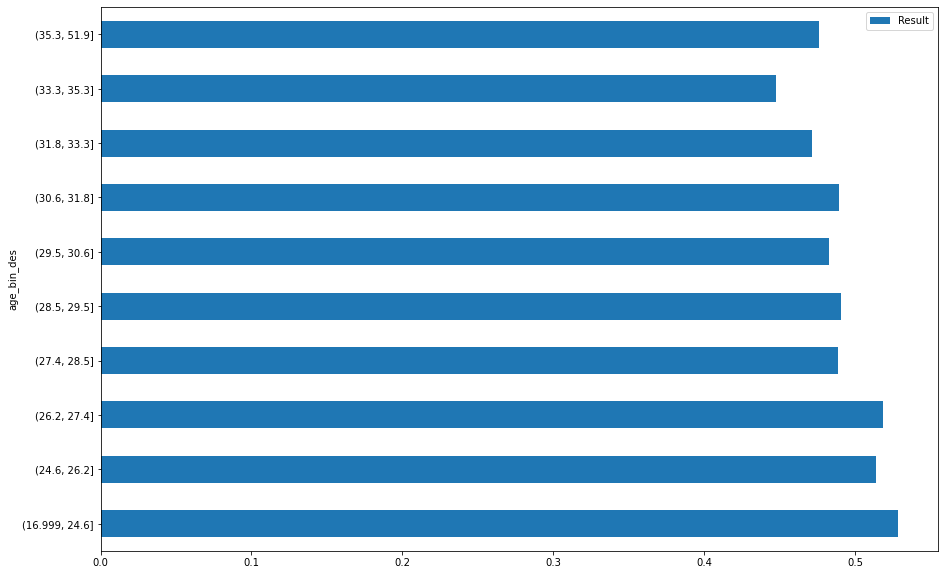

In [118]:
pd.pivot_table(f,values = 'Result', index = 'age_bin_des', aggfunc = np.mean).plot(kind = 'barh',figsize=(15,10))

<AxesSubplot:ylabel='age_bin_des'>

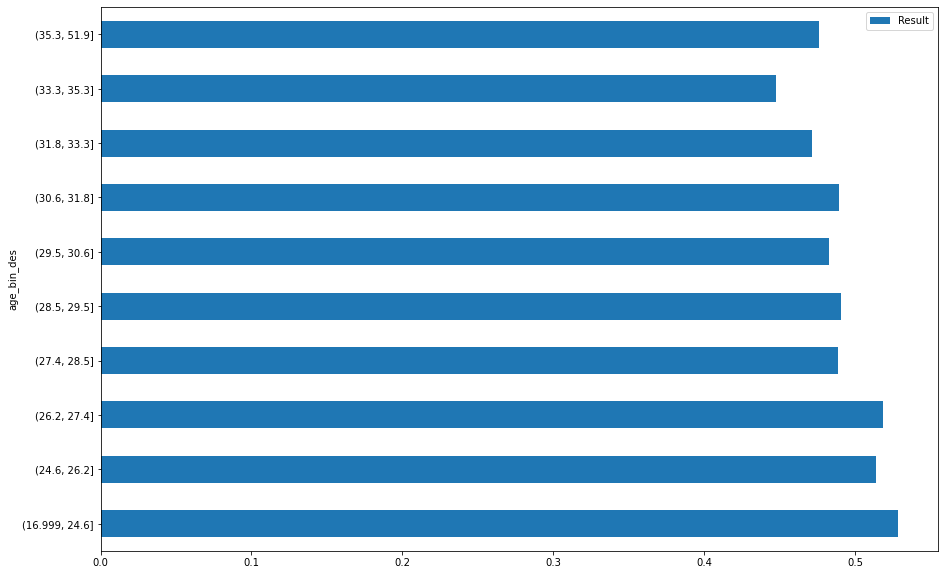

In [119]:
pd.pivot_table(f,values = ['Result'], index = 'age_bin_des', aggfunc = np.mean).plot(kind = 'barh',figsize=(15,10))

In [120]:
f[f.age_bins == 13]

,Result,Result_F,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_,KD_,SigStr_e_,SigStr_t_,TotStr_e_,TotStr_t_,TD_e_,TD_t_,SUB_,PASS_,REV_,Head_e_,Head_t_,Body_e_,Body_t_,Leg_e_,Leg_t_,Distance_e_,Distance_t_,Clinch_e_,Clinch_t_,Ground_e_,Ground_t_,First_F,Last_F,Nick_F,HT_F,Reach_F,Stance_F,W_F,L_F,D_F,DOB_F,FID_F,HT_cm_F,Reach_cm_F,elo_F,eloprob_F,elo_prediction,age_F,fight_time,fight_time_share,weight_class,delta_h,delta_r,w2d_F,l2d_F,time_avg_F,slpm_avg_F,stracc_avg_F,sapm_avg_F,def_avg_F,td_avg_F,tdacc_avg_F,tddef_avg_F,sub_avg_F,lastfight_F,fight_count_F,Head_perT_,Head_acc_,Body_perT_,Body_acc_,Leg_perT_,Leg_acc_,Distance_perT_,Distance_acc_,Clinch_perT_,Clinch_acc_,Ground_perT_,Ground_acc_,PASS_perT_,REV_perT_,KD_perT_,pca_0_F,pca_1_F,pca_2_F,pca_3_F,pca_4_F,pca_5_F,age_bins,age_bin_des
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


##### Save Data

In [121]:
try: r.drop(['HT_F1','HT_F2','WT_F1','WT_F2','Reach_F1','Reach_F2'],axis=1,inplace=True)
except: pass
r.to_csv(f'{cfg.path_data_output}{cfg.scrape_date}_features.csv')